In [3]:
import unittest
import torch
import os.path as osp
import sys

sys.path.insert(0, osp.join('..', 'main'))
sys.path.insert(0, osp.join('..', 'data'))
sys.path.insert(0, osp.join('..', 'common'))
from config import cfg
import argparse

cfg.set_args("0", False)
cfg.num_thread = 1


>>> Using GPU: 0


In [4]:
from model_new_coral import get_model

source_ckpt = r"C:\Users\vladi\RP\InterWild\demo\snapshot_6.pth"
model = get_model(mode='test')
model = torch.nn.DataParallel(model).cuda()

ckpt = torch.load(source_ckpt)
load_info = model.load_state_dict(ckpt['network'], strict=False)

Fix shapedirs bug of MANO


C:\Users\vladi\AppData\Local\Temp\ipykernel_6620\3768563760.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(source_ckpt)


In [5]:
from train_ssa import CustomHandLandmarksDataset

In [6]:
import torchvision.transforms as transforms

# Create validation datasets for target (IR) and source (RGB) domains
val_dataset_target = CustomHandLandmarksDataset(
    image_dir=r"C:\Users\vladi\RP\our_hands_dataset_labeled_previews\IR",
    annotations_path=r"C:\Users\vladi\RP\our_hands_dataset_labeled_previews\combined_FIX_IR.json",
    transform=transforms.ToTensor()
)

val_dataset_source = CustomHandLandmarksDataset(
    image_dir=r"C:\Users\vladi\RP\our_hands_dataset_labeled_previews\RGB", 
    annotations_path=r"C:\Users\vladi\RP\our_hands_dataset_labeled_previews\combined_FIX_RGB.json",
    transform=transforms.ToTensor()
)


In [7]:
model.eval()

DataParallel(
  (module): Model(
    (body_backbone): ResNetBackbone(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu

In [8]:
def extract_features(dataset, model, device='cuda'):
    """
    Extract body and hand features from images in a dataset using a given model.
    
    Args:
        dataset: CustomHandLandmarksDataset instance
        model: torch model for feature extraction
        device: device to run inference on ('cuda' or 'cpu')
    
    Returns:
        tuple: (body_features, hand_features) - Lists of extracted features
    """
    model.eval()
    body_features = []
    hand_features = []
    
    with torch.no_grad():
        for img_path in tqdm(dataset.image_files):
            # Load and preprocess image
            image_path = os.path.join(dataset.image_dir, img_path)
            original_img = load_img(image_path)
            img_height, img_width = original_img.shape[:2]
            
            # Process annotation
            annotation = dataset.image_to_annotation[img_path]
            annotation = HandLandmarks(annotation, width=img_width, height=img_height)
            if annotation.normalized:
                annotation.denormalize()
                
            # Process hand bboxes
            lhand_bbox = np.array(annotation.get_lhand_bbox())
            rhand_bbox = np.array(annotation.get_rhand_bbox())
            
            # Convert and sanitize bboxes
            for bbox in [lhand_bbox, rhand_bbox]:
                bbox[2:] -= bbox[:2]  # xyxy -> xywh
                bbox = sanitize_bbox(bbox, img_width, img_height)
                bbox[2:] += bbox[:2]  # xywh -> xyxy
            
            # Process full image
            bbox = process_bbox([0, 0, img_width, img_height], img_width, img_height)
            img, img2bb_trans, bb2img_trans = generate_patch_image(
                original_img, bbox, 1.0, 0.0, False, cfg.input_img_shape
            )
            
            # Process hand bboxes with dataset method
            lhand_bbox, _ = dataset.process_hand_bbox(lhand_bbox, False, original_img.shape, img2bb_trans)
            rhand_bbox, _ = dataset.process_hand_bbox(rhand_bbox, False, original_img.shape, img2bb_trans)
            
            # Calculate centers and sizes
            lhand_bbox_center = (lhand_bbox[0] + lhand_bbox[1])/2.
            rhand_bbox_center = (rhand_bbox[0] + rhand_bbox[1])/2.
            lhand_bbox_size = lhand_bbox[1] - lhand_bbox[0]
            rhand_bbox_size = rhand_bbox[1] - rhand_bbox[0]
            
            # Prepare image tensor
            img_tensor = transforms.ToTensor()(img.astype(np.float32))/255
            img_tensor = img_tensor.to(device)[None,:,:,:]
            
            # Prepare model inputs
            inputs = {'img': img_tensor}
            targets = {
                'rhand_bbox_center': torch.tensor(rhand_bbox_center).to(device)[None,:],
                'rhand_bbox_size': torch.tensor(rhand_bbox_size).to(device)[None,:],
                'lhand_bbox_center': torch.tensor(lhand_bbox_center).to(device)[None,:],
                'lhand_bbox_size': torch.tensor(lhand_bbox_size).to(device)[None,:]
            }
            meta_info = {
                'source_bb2img_trans': torch.tensor(bb2img_trans).to(device)[None,:,:],
                'target_bb2img_trans': torch.tensor(bb2img_trans).to(device)[None,:,:]
            }
            
            # Get model output
            out = model(inputs, {'img': img_tensor.clone()}, targets, {}, meta_info, 'test')
            
            # Store features
            body_features.append(out["source_body_feat_pooled"])
            hand_features.append(out["source_hand_feat_pooled"])
    
    return body_features, hand_features

In [9]:
import os
from PIL import Image
from utils.preprocessing import load_img, process_bbox, augmentation
from custom_eval_framework import HandLandmarks
import numpy as np
from utils.preprocessing import sanitize_bbox
from utils.preprocessing import generate_patch_image
from tqdm import tqdm

model.eval()
body_pooled_noadapt_target, hand_pooled_noadapt_target = extract_features(val_dataset_target, model, 'cuda')
body_pooled_noadapt_source, hand_pooled_noadapt_source = extract_features(val_dataset_source, model, 'cuda')


100%|██████████| 80/80 [00:59<00:00,  1.35it/s]


In [44]:
del model

In [45]:
torch.cuda.empty_cache()


In [10]:
source_ckpt = r"C:\Users\vladi\RP\InterWild\output\model_dump_old\snapshot_8_pck535handcoral.pth"
model = get_model(mode='test')
model = torch.nn.DataParallel(model).cuda()

ckpt = torch.load(source_ckpt)
load_info = model.load_state_dict(ckpt['network'], strict=False)

C:\Users\vladi\AppData\Local\Temp\ipykernel_6620\907175571.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(source_ckpt)


In [11]:
body_pooled_coral_target, hand_pooled_coral_target = extract_features(val_dataset_target, model, 'cuda')
body_pooled_coral_source, hand_pooled_coral_source = extract_features(val_dataset_source, model, 'cuda')

100%|██████████| 80/80 [00:46<00:00,  1.71it/s]


In [12]:
del model
torch.cuda.empty_cache()



In [13]:
source_ckpt = r"C:\Users\vladi\RP\InterWild\output\model_dump_old\snapshot_8_ssa0507.pth"
model = get_model(mode='test')
model = torch.nn.DataParallel(model).cuda()

ckpt = torch.load(source_ckpt)
load_info = model.load_state_dict(ckpt['network'], strict=False)

C:\Users\vladi\AppData\Local\Temp\ipykernel_6620\959446807.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(source_ckpt)


In [14]:
body_pooled_ssa_target, hand_pooled_ssa_target = extract_features(val_dataset_target, model, 'cuda')
body_pooled_ssa_source, hand_pooled_ssa_source = extract_features(val_dataset_source, model, 'cuda')

100%|██████████| 80/80 [00:25<00:00,  3.19it/s]


In [16]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
def visualize_and_save_features(source_features, target_features, title, save_path):
    # Convert lists of tensors to numpy arrays
    source_features = np.vstack([tensor.cpu().numpy() for tensor in source_features])
    target_features = np.vstack([tensor.cpu().numpy() for tensor in target_features])

    # Combine features for PCA
    all_features = np.vstack([source_features, target_features])

    # Perform PCA
    pca = PCA(n_components=2)
    all_features_pca = pca.fit_transform(all_features)

    # Split back into source and target
    source_pca = all_features_pca[:len(source_features)]
    target_pca = all_features_pca[len(source_features):]

    # Create the scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(source_pca[:, 0], source_pca[:, 1], c='blue', label='RGB', alpha=0.6)
    plt.scatter(target_pca[:, 0], target_pca[:, 1], c='red', label='IR', alpha=0.6)

    plt.title(title)
    plt.xlabel(f'First Principal Component')
    plt.ylabel(f'Second Principal Component')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save the figure
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()


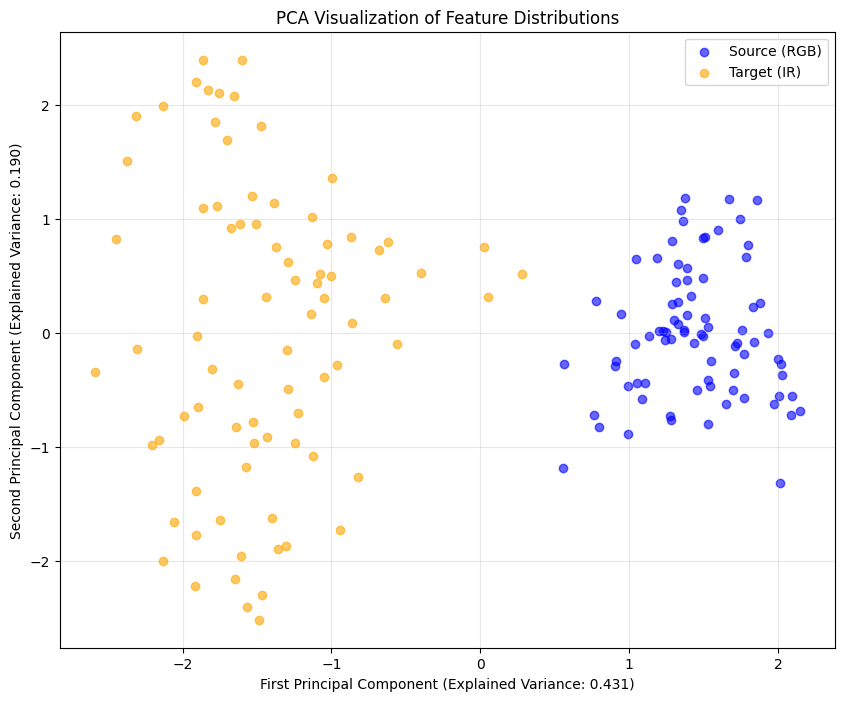

In [37]:
visualize_features(body_pooled_noadapt_source, body_pooled_noadapt_target)

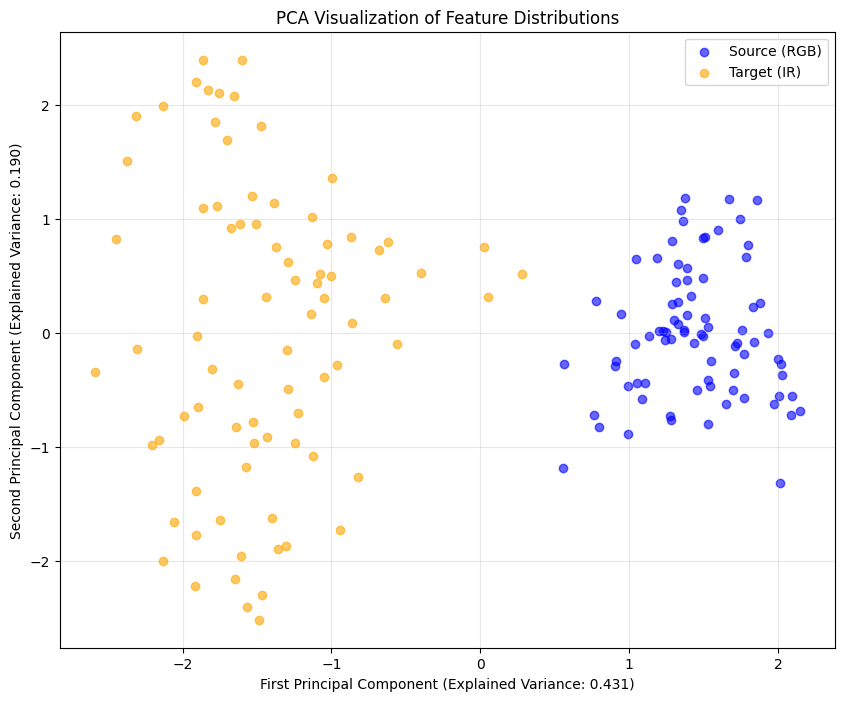

In [40]:
visualize_features(body_pooled_coral_source, body_pooled_coral_target)

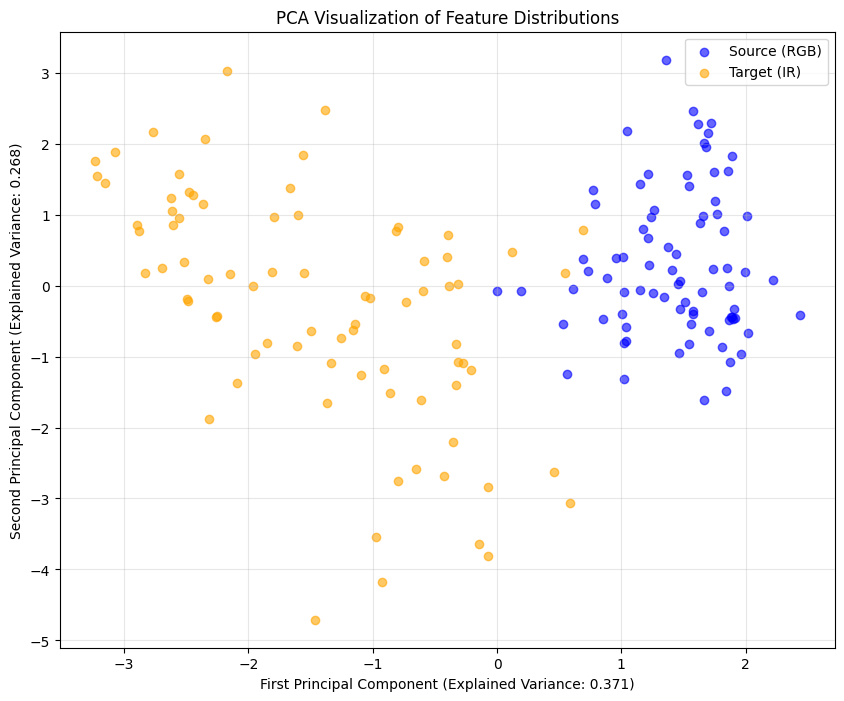

In [41]:
visualize_features(body_pooled_ssa_source, body_pooled_ssa_target)

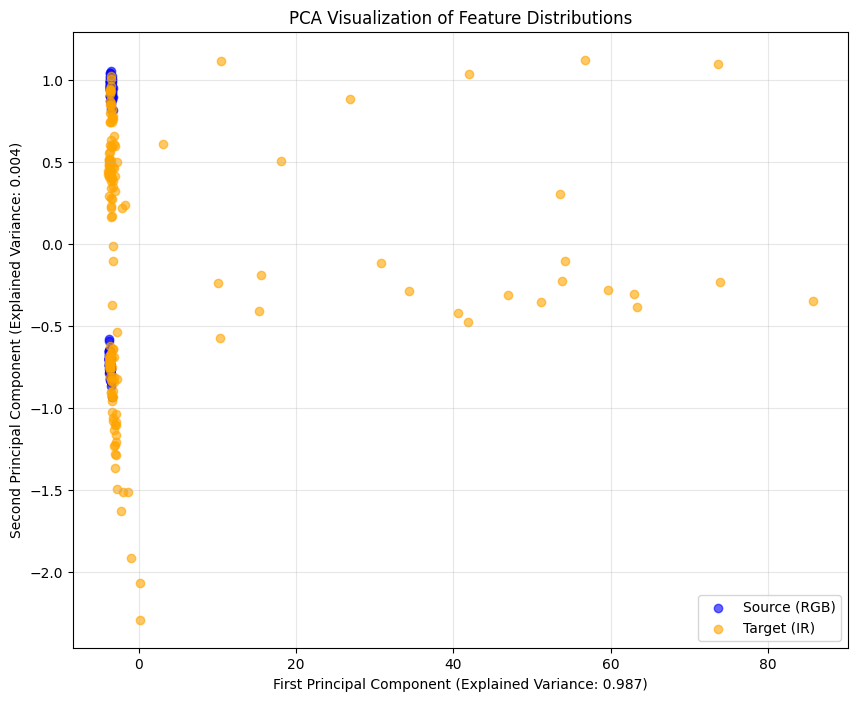

In [48]:
visualize_features(hand_pooled_noadapt_source, hand_pooled_noadapt_target) 

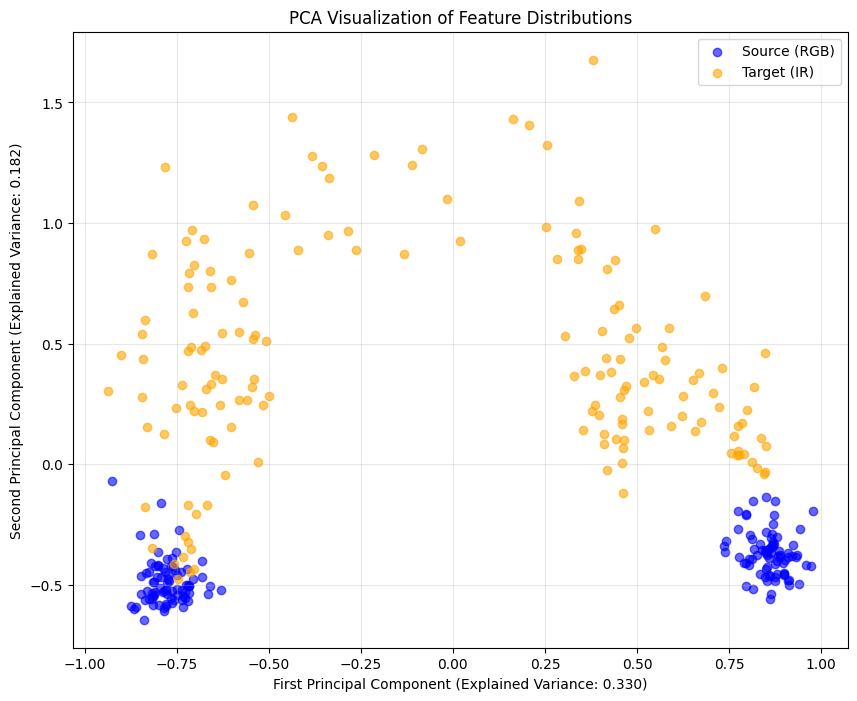

In [49]:
visualize_features(hand_pooled_coral_source, hand_pooled_coral_target) 

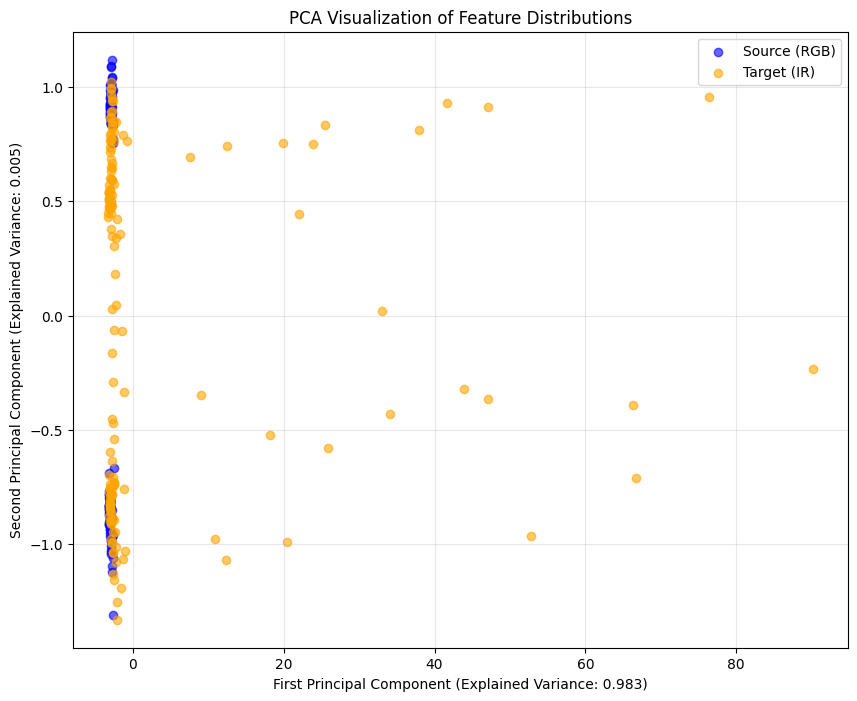

In [42]:
visualize_features(hand_pooled_ssa_source, hand_pooled_ssa_target)

In [17]:
save_dir = r"C:\Users\vladi\RP\RP_Docs\tex\images"

# Save all visualizations
visualize_and_save_features(
    body_pooled_noadapt_source, body_pooled_noadapt_target,
    'Body Features - No Adaptation',
    osp.join(save_dir, 'pca_body_noadapt.png')
)

visualize_and_save_features(
    body_pooled_coral_source, body_pooled_coral_target,
    'Body Features - Deep CORAL',
    osp.join(save_dir, 'pca_body_coral.png')
)

visualize_and_save_features(
    body_pooled_ssa_source, body_pooled_ssa_target,
    'Body Features - SSA (K=20)',
    osp.join(save_dir, 'pca_body_ssa.png')
)

visualize_and_save_features(
    hand_pooled_noadapt_source, hand_pooled_noadapt_target,
    'Hand Features - No Adaptation',
    osp.join(save_dir, 'pca_hand_noadapt.png')
)

visualize_and_save_features(
    hand_pooled_coral_source, hand_pooled_coral_target,
    'Hand Features - Deep CORAL',
    osp.join(save_dir, 'pca_hand_coral.png')
)

visualize_and_save_features(
    hand_pooled_ssa_source, hand_pooled_ssa_target,
    'Hand Features - SSA (K=20)',
    osp.join(save_dir, 'pca_hand_ssa.png')
)